In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import re
import os

os.chdir('..')
os.chdir('results')

In [2]:
def get_path(dataset='FordA', model_name='ResidualCNN', reg=True, exp_name=None):
    attack_type = 'fgsm_disc_attack' if reg else 'fgsm_attack'
    exp = '_' + exp_name if exp_name else ''
    
    path = '/'.join([dataset, model_name, 'attack', attack_type + exp])

    return path



def combined_df(dataset='FordA', model_name='ResidualCNN', reg=True, exp_name=None):

    path = get_path(dataset=dataset, model_name=model_name, reg=reg, exp_name=exp_name)
    
    files = os.listdir(path)
    files = [f for f in files if f.endswith('.csv')]

    pattern = r"(?<==).*?(?=.csv)"
    id_pattern = fr"(?<={dataset}_).*?(?=_alpha)"

    all_res = pd.DataFrame()

    for file in files:
        curr_res = pd.read_csv(path + '/' + file, index_col=0)

        curr_res['alpha'] = float(re.search(pattern, file)[0])
        curr_res['model_id'] = re.search(id_pattern, file)[0]

        curr_res.columns = [column.strip(' ') for column in curr_res.columns] 

        all_res = pd.concat([all_res, curr_res], axis=0)

    return all_res.reset_index(drop=True)

def aggregated_results(
    dataset='FordA', 
    model_name='ResidualCNN', 
    exp_name='',
    reg=True,  
    metr='F_EFF_CONC',
    metr_max=True,
    k=1,
    vis = False,
    params=['ACC', 'PROB_HID'],
    figsize=(20, 30),
    save_pic=False):

    all_df = combined_df(dataset=dataset, model_name=model_name, reg=reg, exp_name=exp_name)

    grouped = all_df.groupby(['eps', 'alpha'])
    result = grouped.apply(lambda x: x.nlargest(k, metr, keep='last') if metr_max else x.nsmallest(k, metr, keep='last'))


    if vis:
        
        fig, ax = plt.subplots(result['alpha'].nunique(), result['eps'].nunique(), figsize=figsize, sharey=True)
        fig.suptitle(f'{dataset}_{model_name}')

        all_alps = result['alpha'].unique()
        all_eps = result['eps'].unique()

        path = get_path(dataset=dataset, model_name=model_name, reg=reg, exp_name=exp_name)

        for i, row in result.iterrows():

            alp = int(row['alpha']) if row['alpha'].is_integer() else row['alpha']
            eps = row['eps']

            file_path = path + '/' + f'aa_res_{dataset}_{int(row["model_id"])}_alpha={alp}.csv'

            curr_df = pd.read_csv(file_path, index_col=0)
            curr_df.columns = [column.strip(' ') for column in curr_df.columns]

            curr_df = curr_df[curr_df['eps']==eps].set_index('step_id')

            eps_id = np.where(all_eps==eps)[0][0]
            alp_id = np.where(all_alps==alp)[0][0]

            ax[alp_id, eps_id].plot(curr_df[params])
            ax[alp_id, eps_id].axvline(int(row["step_id"]), ls='--', alpha=0.2, color='black')

            ax[alp_id, eps_id].set_title(f'eps={eps}, alpha={alp}, {metr}={row[metr]}, step={int(row["step_id"])}')
            ax[alp_id, eps_id].legend(params)
        
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)

        if save_pic:
            plt.savefig(f'../{dataset}_{model_name}.jpeg', dpi=120)

    return result

In [3]:
# aggregated_results(dataset='FordA', model_name='PatchTST', exp_name="CLEAN", vis=False, params=['ACC', 'PROB_HID', 'ACC_DISC'])

In [4]:
res = pd.DataFrame()

for model in ['LSTM', 'ResidualCNN', 'RNNA', 'TST', 'S4', 'PatchTST']:
    for ds in ['FordA', 'Strawberry', 'GunPointMaleVersusFemale', 'FreezerRegularTrain']:
        try:
            aa = aggregated_results(dataset=ds, model_name=model, exp_name="CLEAN", k = 1000)
            aa['model'] = model
            aa['dataset'] = ds

            res = pd.concat([res, aa], axis=0)
        except:
            print(ds, model)

GunPointMaleVersusFemale LSTM
FreezerRegularTrain LSTM
FordA TST


In [5]:
res.groupby(['dataset', 'model']).max().reset_index().pivot(index='model', columns='dataset', values='F_EFF_CONC')

dataset,FordA,FreezerRegularTrain,GunPointMaleVersusFemale,Strawberry
model,,,,
LSTM,0.4119,NaN,NaN,0.8624
PatchTST,0.8326,0.9013,0.6292,0.9757
RNNA,0.2341,0.5445,0.9936,0.6746
ResidualCNN,0.2988,0.9996,0.2780,0.0768
S4,0.5981,0.9871,0.8276,0.8072
TST,NaN,0.8516,0.8054,0.5437


In [6]:
tmp = res.groupby(['dataset', 'model'])['F_EFF_CONC'].idxmax().to_frame()

tmp['eps'] = tmp['F_EFF_CONC'].apply(lambda x: x[0])
tmp['alpha'] = tmp['F_EFF_CONC'].apply(lambda x: x[1])
tmp['F_EFF_CONC'] = res.groupby(['dataset', 'model'])['F_EFF_CONC'].max()

In [7]:
tmp.reset_index().pivot(index='model', columns='dataset')

F_EFF_CONC                                               \
dataset          FordA FreezerRegularTrain GunPointMaleVersusFemale   
model                                                                 
LSTM            0.4119                 NaN                      NaN   
PatchTST        0.8326              0.9013                   0.6292   
RNNA            0.2341              0.5445                   0.9936   
ResidualCNN     0.2988              0.9996                   0.2780   
S4              0.5981              0.9871                   0.8276   
TST                NaN              0.8516                   0.8054   

                          eps                                               \
dataset     Strawberry  FordA FreezerRegularTrain GunPointMaleVersusFemale   
model                                                                        
LSTM            0.8624  0.005                 NaN                      NaN   
PatchTST        0.9757  0.030               0.100                    0.030   
RNNA            0.6746  0.005               0.100                    0.100   
ResidualCNN     0.0768  0.005               0.100                    0.005   
S4              0.8072  0.005               0.030                    0.030   
TST             0.5437    NaN               0.005                    0.030   

                       alpha                                               \
dataset     Strawberry FordA FreezerRegularTrain GunPointMaleVersusFemale   
model                                                                       
LSTM             0.030  0.10                 NaN                      NaN   
PatchTST         0.030  0.10                 1.0                     0.10   
RNNA             0.005  0.10                10.0                     0.10   
ResidualCNN      0.005  0.01                 0.1                     0.01   
S4               0.005  0.10                 1.0                     0.10   
TST              0.005   NaN                 0.1                     0.10   

                        
dataset     Strawberry  
model                   
LSTM               1.0  
PatchTST           0.1  
RNNA               1.0  
ResidualCNN        1.0  
S4                 1.0  
TST                0.1

In [8]:
best_metr = tmp.reset_index().pivot(index='model', columns='dataset')

datasets = best_metr['F_EFF_CONC'].columns
models = best_metr.index

metr = ['ACC', 'PROB_HID', 'ACC_DISC']

save = True

TST FordA nan
LSTM FreezerRegularTrain nan
LSTM GunPointMaleVersusFemale nan


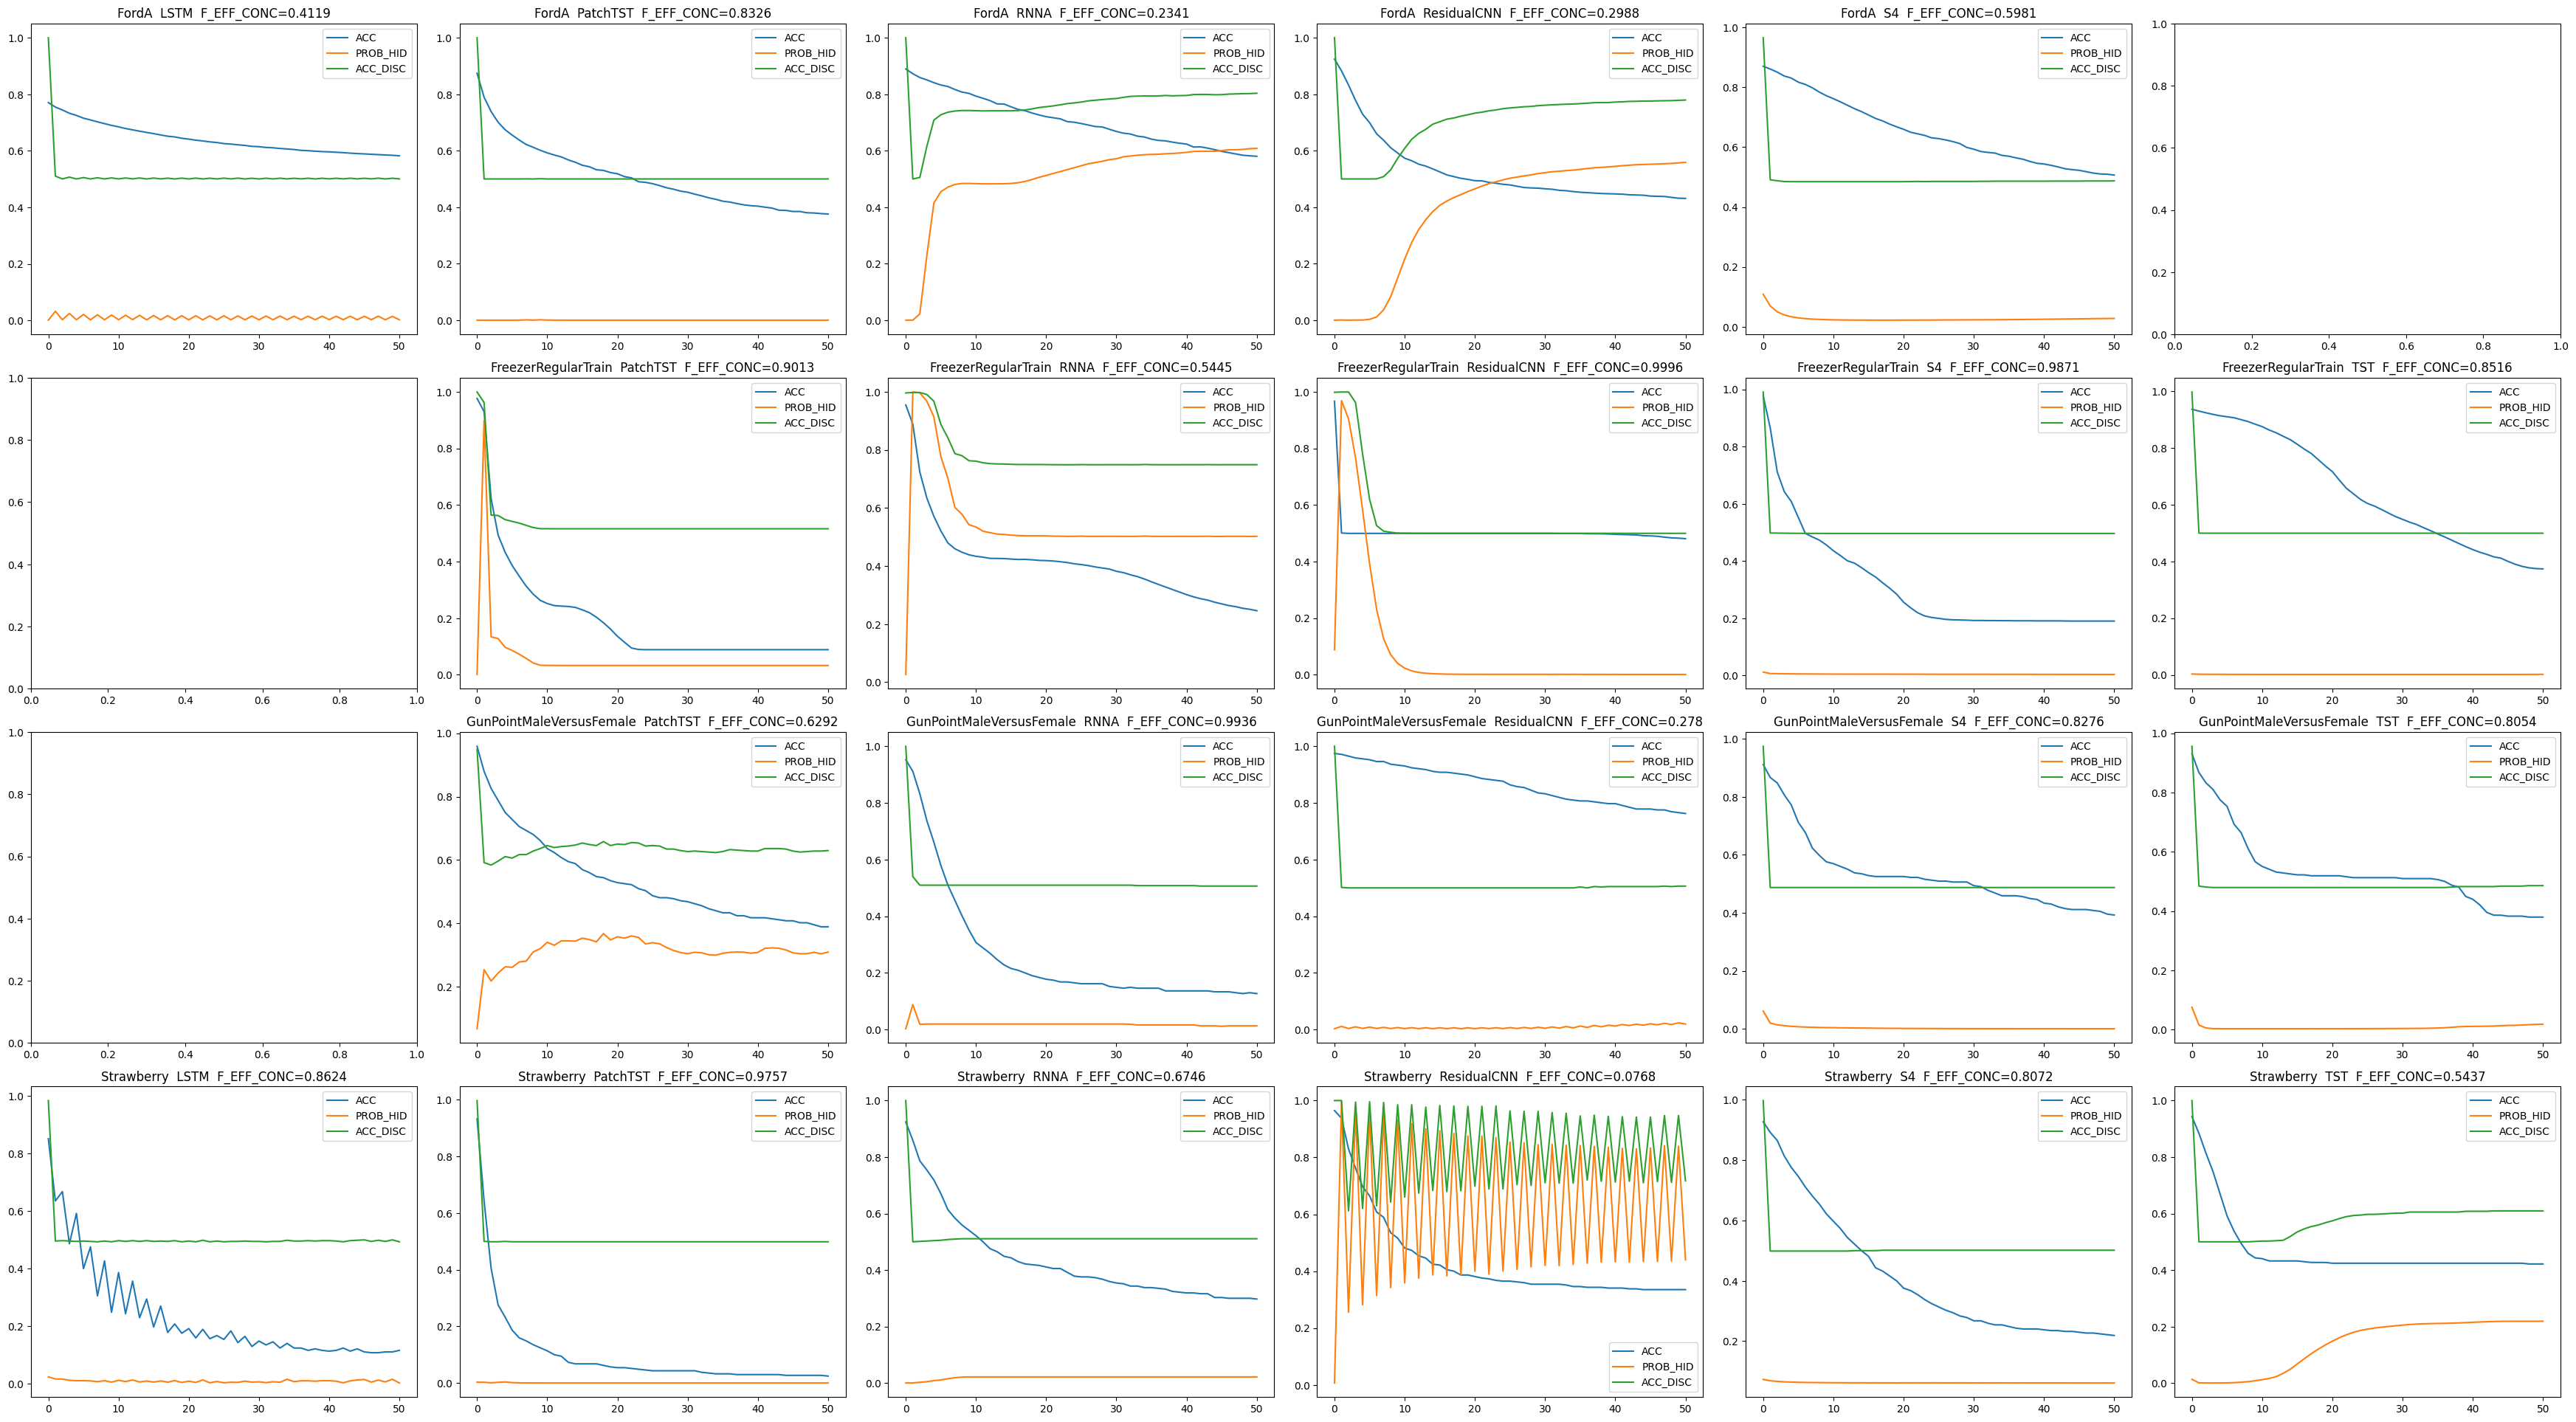

In [9]:
fig, ax = plt.subplots(len(datasets), len(models), figsize=(35, 20))

for i, dataset in enumerate(datasets):
    for j, model in enumerate(models):

        eps = best_metr['eps'].loc[model, dataset]

        alpha = best_metr['alpha'].loc[model, dataset]
        alpha = int(alpha) if alpha.is_integer() else alpha

        path = get_path(dataset, model, exp_name='CLEAN')

        try:
            curr_res = pd.read_csv(path + '/' + f'aa_res_{dataset}_0_alpha={alpha}.csv', index_col=0)
            curr_res.columns = [col.strip(' ') for col in curr_res.columns]
            
            curr_res = curr_res[curr_res['eps'] == eps].set_index('step_id')
            ax[i, j].plot(curr_res[metr])
            ax[i, j].set_title(f'{dataset}  {model}  F_EFF_CONC={curr_res["F_EFF_CONC"].max()}')
            ax[i, j].legend(metr)

        except:
            print(model, dataset, alpha)
        
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)

if save:
    fig.savefig('../img_1.jpeg', dpi=200)

PARAMS COUNT

In [9]:
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)
os.chdir('..')

from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

import pandas as pd

import torch

from src.config import get_attack, get_criterion, get_disc_list, get_model
from src.data import MyDataset, load_data, transform_data
from src.estimation.estimators import AttackEstimator

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [10]:
params = pd.DataFrame()
ds_len = pd.Series()

In [11]:
datasets = ['FordA', 'Strawberry', 'FreezerRegularTrain', 'GunPointMaleVersusFemale']
models = ['LSTM', 'ResidualCNN', 'RNNA', 'TST', 'S4', 'PatchTST']

device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

for ds in datasets:
    for model in models:
        try:
            path = 'results' + '/' + ds + '/' + model + '/attack/fgsm_disc_attack_CLEAN'
            files = os.listdir(path)
            file = [f for f in files if f.startswith('config_2024')]

            if len(file) > 0:
                cfg = OmegaConf.load(path + '/' + file[-1])
            
            else:
                GlobalHydra.instance().clear()
                initialize(config_path= '../' + path + '/config_folder')
                cfg = compose('attack_run_config.yaml')

            attack_model_path = os.path.join(
                cfg["model_folder"],
                f"model_{cfg['model_id_attack']}_{cfg['dataset']['name']}.pt",
            )

            attack_model = get_model(
                cfg["attack_model"]["name"],
                cfg["attack_model"]["params"],
                path=attack_model_path,
                device=device,
                train_mode=cfg["attack_model"]["attack_train_mode"],
            )
            param_num = sum(p.numel() for p in attack_model.parameters())
            
            params.loc[model, ds] = param_num
            ds_len[ds] = cfg['dataset']['seq_len']

        except:
            print(ds, model, 'error')

FordA TST error
FreezerRegularTrain LSTM error
FreezerRegularTrain TST error
GunPointMaleVersusFemale LSTM error


In [12]:
params

,FordA,Strawberry,FreezerRegularTrain,GunPointMaleVersusFemale
LSTM,36101.0,36101.0,NaN,NaN
ResidualCNN,256130.0,256130.0,256130.0,256130.0
RNNA,377985.0,344065.0,352513.0,333185.0
S4,29121.0,29121.0,29121.0,29121.0
PatchTST,6376965.0,6343173.0,6351365.0,6331909.0
TST,NaN,652929.0,NaN,631169.0


In [16]:
agg = res.reset_index(drop=True).copy(deep=True)

In [17]:
gg = agg.copy(deep=True)

In [18]:
for ds in gg['dataset'].unique():
    gg.loc[gg[gg.dataset==ds].index, 'seq_len'] = ds_len[ds]

for ds in datasets:
    for model in models:
        idx = gg[(gg.model==model)&(gg.dataset==ds)].index

        gg.loc[idx, 'param_count'] = params.loc[model, ds]

# VISUALIZE

In [19]:
import seaborn as sns

In [20]:
table = gg[['EFF', 'CONC', 'F_EFF_CONC', 'step_id', 'param_count', 'seq_len', 'eps', 'alpha', 'model', ]]

corr_table = pd.get_dummies(table, dtype=float).corr()

In [21]:
corr_table[['EFF', 'CONC', 'F_EFF_CONC']]

,EFF,CONC,F_EFF_CONC
EFF,1.000000,-0.438528,0.025815
CONC,-0.438528,1.000000,0.741635
F_EFF_CONC,0.025815,0.741635,1.000000
step_id,0.267750,0.062102,0.179339
param_count,-0.067198,0.263493,0.206787
seq_len,0.121302,-0.264122,-0.185063
eps,0.454333,-0.352012,-0.135753
alpha,-0.293078,0.184266,-0.021262
model_LSTM,0.134683,-0.118878,-0.077523
model_PatchTST,-0.048920,0.257493,0.214828
